In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern,WhiteKernel, ConstantKernel as C
import warnings
warnings.filterwarnings('ignore')

from utils import plot_GMM


In [7]:
from utils import load_lasa
def load(   shape='DoubleBendedLine'):

    X, Y = load_lasa(shape)
    return X, Y


In [8]:
def var_gradient( x, X, K_inv, kernel, kernel_params_): # GP with RBF kernel 
    """Input has shape n_query x n_features. 
    Output is the  derivative of the predicted variance 
    Each utput has shape n_query x n_features x n_outputs.
    The output in position i,j,k has the derivative respect to the j-th feature of the k-th output, in position of the i-th data point.
    For the derivative of sigma n_outputs is equal to 1"""
    lscale=  kernel_params_[0].reshape(1,-1)
    X_T= (X).transpose()
    x_T = x.transpose()
    lscale_T= lscale.transpose()
    X_reshaped = X_T[:,  np.newaxis,:]
    x_reshaped = x_T[:,  :, np.newaxis]

    k_star=   kernel( x, X)
    k_star_T=k_star.transpose()
    beta = -2 * np.matmul( K_inv, k_star_T)
    lascale_rehaped= lscale_T[:,  :, np.newaxis]

    # Calculate the difference
    difference_matrix =  X_reshaped - x_reshaped
    
    coefficient= difference_matrix/ ( lascale_rehaped** 2) 

    #coefficient of dk_dx_prime that multiplies the kernel itself  (x - x_prime)/sigma_l**2
    dk_star_dx=  coefficient * k_star
    dsigma_dx = np.sum(dk_star_dx * beta.T, axis=2)
    dsigma_dx= dsigma_dx.transpose()   
    return dsigma_dx
    
def global_attractor(X,X_goal):
    Y=(X_goal-X)
    Y_norm=np.linalg.norm(Y)
    mask= Y_norm>0.0000001
    Y[mask,:]=Y[mask,:]/Y_norm[mask]
    return Y 

In [9]:
X, X_dot= load('Sshape')
# downsample the data
X=X[::10,:]
X_dot=X_dot[::10,:]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f465028d280>
Traceback (most recent call last):
  File "/home/oem/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/oem/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/oem/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/oem/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x

Not empty components:
0
1
6
7
13
16


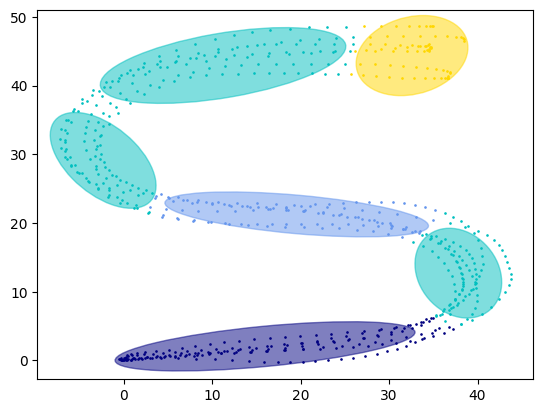

In [10]:
#create empty list for each components of the mixture
GP_=[]
IND=[]
KERNEL_PAR=[]
KERNEL=[]
KINV=[]
X_=[]

k = C(constant_value=np.sqrt(0.1))  * Matern(1*np.ones(2), nu=1.5) + WhiteKernel(0.01 )
gp = GaussianProcessRegressor(kernel=k, alpha=1e-10, n_restarts_optimizer=5)
gmm = BayesianGaussianMixture(n_components=20,weight_concentration_prior_type='dirichlet_process',weight_concentration_prior=1).fit(X)

plot_GMM(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0)

index=gmm.predict(X)
print("Not empty components:")
for i in range(gmm.n_components):
    if not np.any(index== i):
        continue
    print(i)    
    X_0=(X[index==i,:]) 
    Y_0=(X_dot[index==i,:])
    gp = GaussianProcessRegressor(kernel=k, alpha=1e-10, n_restarts_optimizer=5)
    gp.fit(X_0,Y_0)
    gp_kernels_ = gp.kernel_
    kernel_params_ = [gp_kernels_.get_params()['k1__k2__length_scale'], gp_kernels_.get_params()['k1']]
    noise_var_ = gp.alpha + gp_kernels_.get_params()['k2__noise_level']
    K_ = gp_kernels_(X_0, X_0) + (noise_var_ * np.eye(len(X_0)))
    K_inv = np.linalg.inv(K_)
    KERNEL.append(gp_kernels_)
    KINV.append(K_inv)
    KERNEL_PAR.append(kernel_params_)
    GP_.append(gp)
    X_.append(X_0)
    IND.append(i)

0
1
2
3
4
5


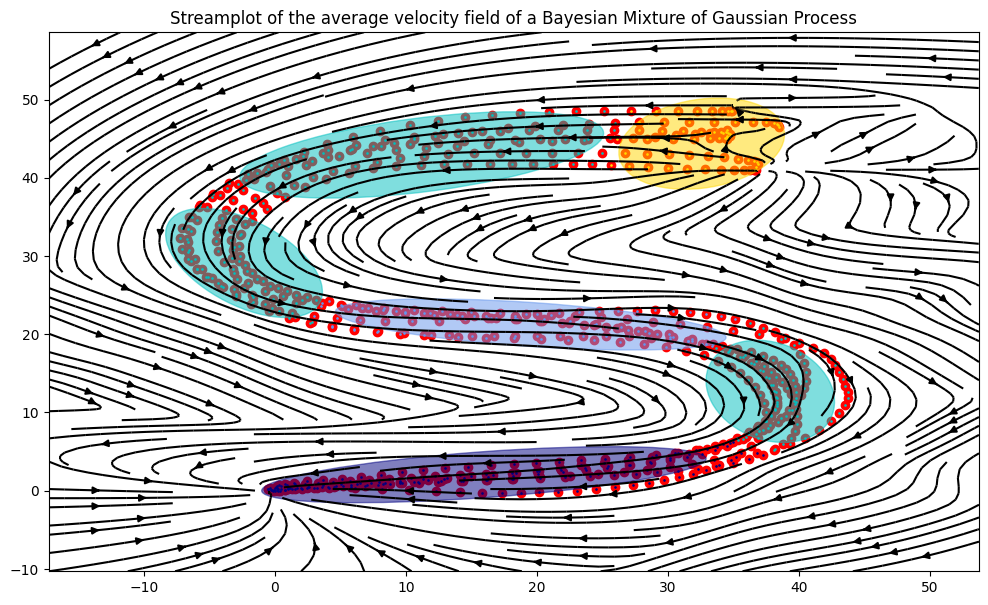

In [15]:
x=np.linspace(np.min(X[:,0]-10), np.max(X[:,0]+10), 100)
y=np.linspace(np.min(X[:,1]-10), np.max(X[:,1]+10), 100)
# Creating grids
XX, YY = np.meshgrid(x, y)
u=np.ones((len(x),len(y)))
v=np.ones((len(x),len(y)))
pos=np.hstack([XX.reshape(-1,1), YY.reshape(-1,1)])
weights=(gmm.predict_proba(pos))

# Initialize an empty numpy array
grad_ = []
vel_ = []
var_ = []
std_ = []
weights_ = []

for k in range(np.shape(GP_)[0]):
    print(k)
    [vel, std]=GP_[k].predict(pos, return_std=True)
    grad=var_gradient( pos, X_[k], KINV[k], KERNEL[k], KERNEL_PAR[k][0])

    grad_.append(grad)
    vel_.append(vel)
    std_.append(std)
    weights_.append(weights[:,IND[k]])

grad_=np.array(grad_)
vel_=np.array(vel_)
std_=np.array(std_)
weights_=np.array(weights_)[:,:,np.newaxis]

grad_avg= np.sum( grad_ * weights_, axis=0)
std_avg=  np.sum( std_ * weights_, axis=0)
vel_avg=  np.sum( vel_ * weights_, axis=0)

u = vel_avg[:,0].reshape(100,100)
v = vel_avg[:,1].reshape(100,100)

        
fig = plt.figure(figsize = (12, 7))
plt.streamplot(XX, YY, u, v, density = 2, color=[0,0,0])
plt.scatter(X[:,0],X[:,1], color=[1,0,0])
plot_GMM(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0)
plt.title('Streamplot of the average velocity field of a Bayesian Mixture of Gaussian Process')
plt.show()

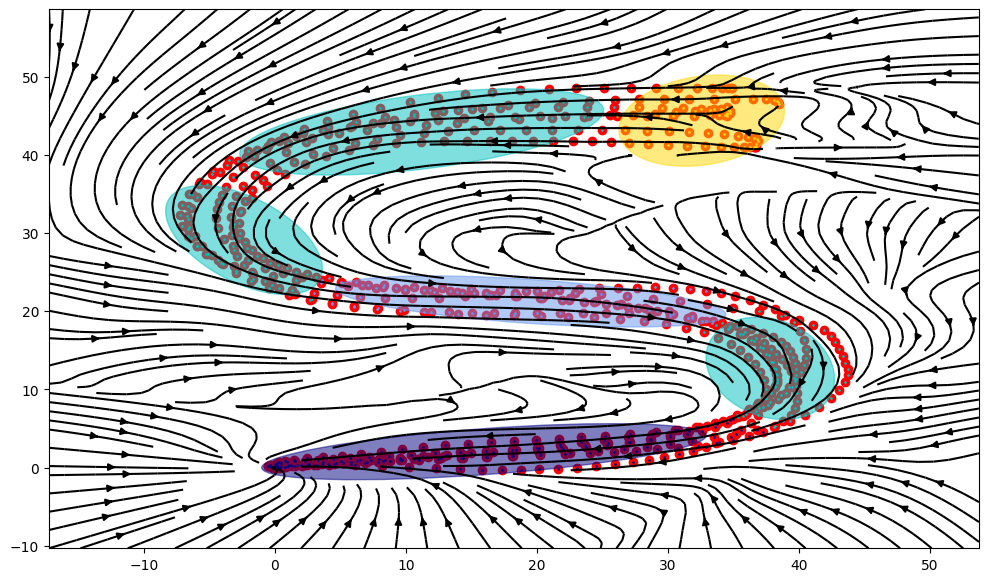

In [12]:
x=np.linspace(np.min(X[:,0]-10), np.max(X[:,0]+10), 100)
y=np.linspace(np.min(X[:,1]-10), np.max(X[:,1]+10), 100)
# Creating grids
XX, YY = np.meshgrid(x, y)
u=np.ones((len(x),len(y)))
v=np.ones((len(x),len(y)))
pos=np.hstack([XX.reshape(-1,1), YY.reshape(-1,1)])
weights=(gmm.predict_proba(pos))

# Initialize an empty numpy array
grad_ = []
vel_ = []
var_ = []
std_ = []
weights_ = []

for k in range(np.shape(GP_)[0]):
    [vel, std]=GP_[k].predict(pos, return_std=True)
    grad=var_gradient( pos, X_[k], KINV[k], KERNEL[k], KERNEL_PAR[k][0])

    grad_.append(grad)
    vel_.append(vel)
    std_.append(std)
    weights_.append(weights[:,IND[k]])

grad_=np.array(grad_)
vel_=np.array(vel_)
std_=np.array(std_)
weights_=np.array(weights_)[:,:,np.newaxis]

grad_avg= np.sum( grad_ * weights_, axis=0)
std_avg=  np.sum( std_ * weights_, axis=0)
vel_avg=  np.sum( vel_ * weights_, axis=0)

stable_field= grad_avg/ np.linalg.norm(grad_avg, axis=1)[:, np.newaxis]

vel_stable = vel_avg - std_avg* stable_field

u = vel_stable[:,0].reshape(100,100)
v = vel_stable[:,1].reshape(100,100)

        
fig = plt.figure(figsize = (12, 7))
plt.streamplot(XX, YY, u, v, density = 2, color=[0,0,0])
plt.scatter(X[:,0],X[:,1], color=[1,0,0])
plot_GMM(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0)

plt.show()


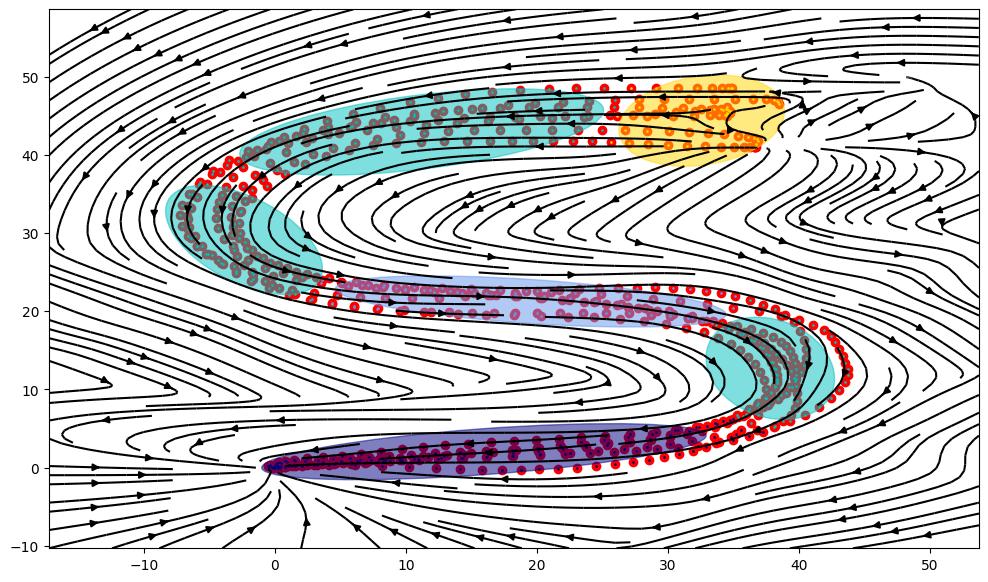

In [13]:
x=np.linspace(np.min(X[:,0]-10), np.max(X[:,0]+10), 100)
y=np.linspace(np.min(X[:,1]-10), np.max(X[:,1]+10), 100)
# Creating grids
XX, YY = np.meshgrid(x, y)
u=np.ones((len(x),len(y)))
v=np.ones((len(x),len(y)))
pos=np.hstack([XX.reshape(-1,1), YY.reshape(-1,1)])
weights=(gmm.predict_proba(pos))

# Initialize an empty numpy array
grad_ = []
vel_ = []
var_ = []
std_ = []
weights_ = []

for k in range(np.shape(GP_)[0]):
    [vel, std]=GP_[k].predict(pos, return_std=True)
    vel_.append(vel)
    std_.append(std)
    weights_.append(weights[:,IND[k]])

vel_=np.array(vel_)
std_=np.array(std_)
weights_=np.array(weights_)[:,:,np.newaxis]

std_avg=  np.sum( std_ * weights_, axis=0)
vel_avg=  np.sum( vel_ * weights_, axis=0)

stable_field= global_attractor(pos, X[-1,:])

vel_stable = vel_avg + 3* std_avg* stable_field

u = vel_stable[:,0].reshape(100,100)
v = vel_stable[:,1].reshape(100,100)

        
fig = plt.figure(figsize = (12, 7))
plt.streamplot(XX, YY, u, v, density = 2, color=[0,0,0])
plt.scatter(X[:,0],X[:,1], color=[1,0,0])
plot_GMM(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0)

plt.show()